
<center>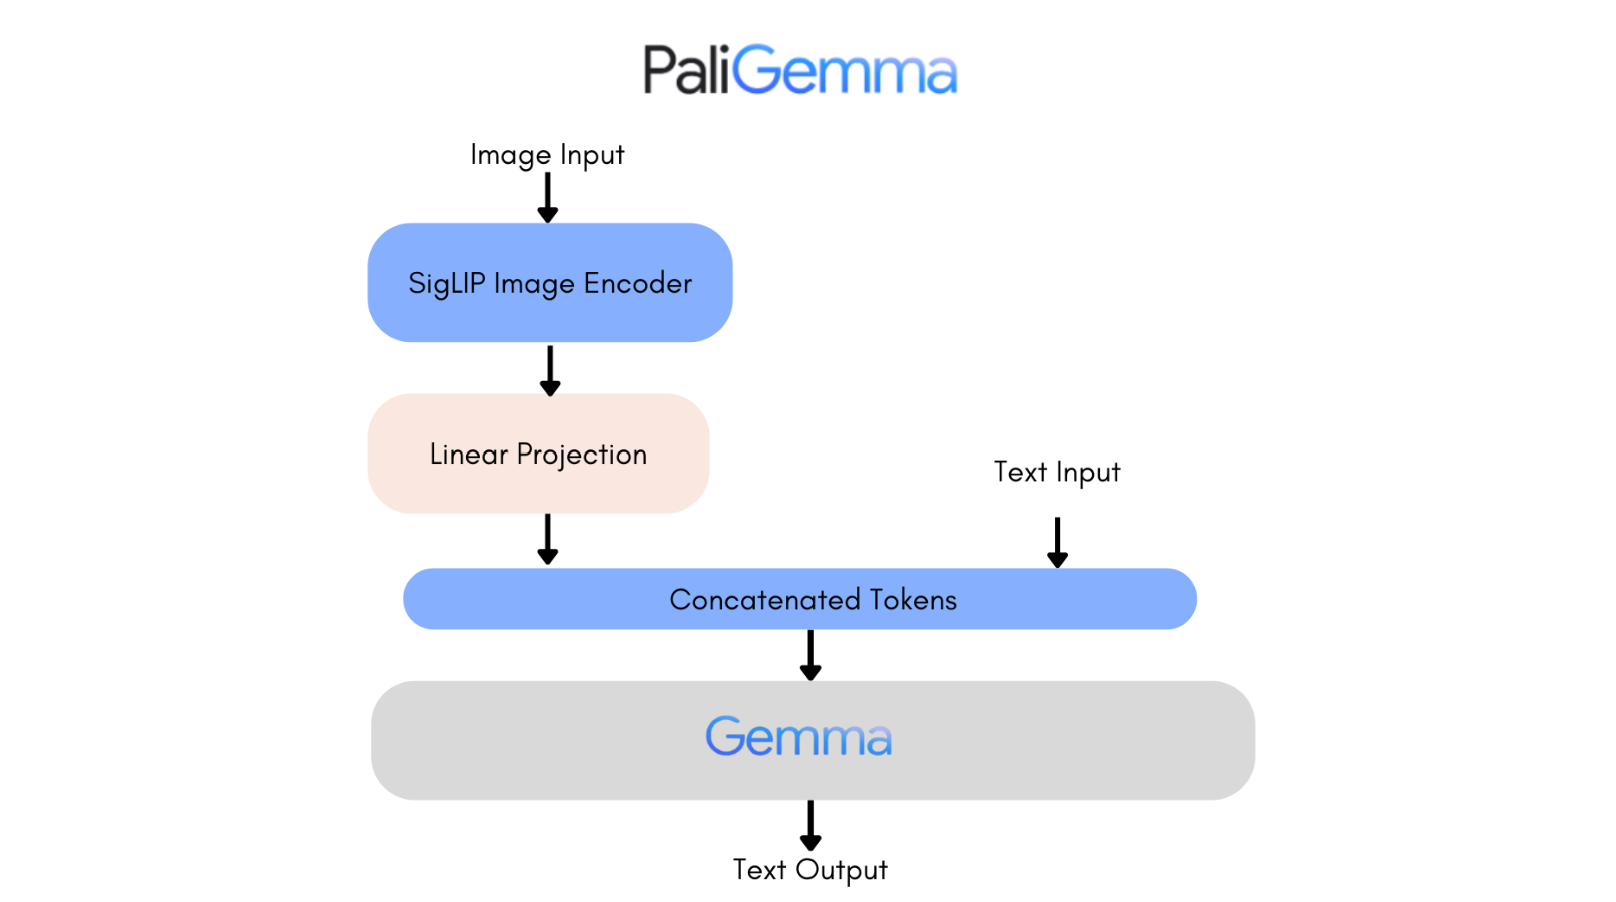

### [Source: Hugging Face Blog on PaliGemma](https://huggingface.co/blog/paligemma) </center>

# Fine-tune PaliGemma 
## FineTunning with QLoRA (4 bit)
## Use cases: image -> JSON 


Datset Utilized for FineTuning: https://huggingface.co/datasets/naver-clova-ix/cord-v2


## Set-up environment

We install 🤗 Transformers from source here since some updates were included which are not yet in a PyPi release.

In [1]:
!pip install -q --upgrade git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


For training the model, we will use PyTorch Lightning (this could of course be replaced by native PyTorch, 🤗 Accelerate or the 🤗 Trainer API).

In [2]:
!pip install -q datasets lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.7 MB/s eta 0:00:00a 0:00:01


In [3]:
!pip install -q peft accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 25.1 MB/s eta 0:00:00:00:0100:01


We'll also use Weights and Biases for logging (seeing our loss going down during training).

In [4]:
!pip install -q --upgrade wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 82.9 MB/s eta 0:00:00:00:0100:01


## Define variables

Here we define some variables which we'll use throughout this notebook.

In [5]:
REPO_ID = "google/paligemma-3b-pt-224"

MAX_LENGTH = 512


## Load dataset



In [6]:
from datasets import load_dataset

dataset = load_dataset("naver-clova-ix/cord-v2")

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

(…)-00000-of-00004-b4aaeceff1d90ecb.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00001-of-00004-7dbbe248962764c5.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

(…)-00002-of-00004-688fe1305a55e5cc.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

(…)-00003-of-00004-2d0cd200555ed7fd.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

(…)-00000-of-00001-cc3c5779fe22e8ca.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

(…)-00000-of-00001-9c204eb3f4e11791.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Let's check out the dataset:

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})



Let's check the first training example:

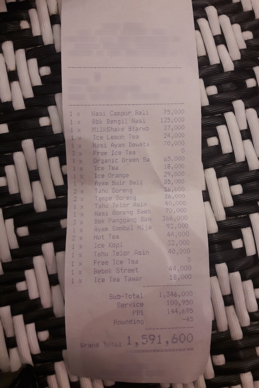

In [8]:
example = dataset['train'][0]
image = example["image"]
# resize image for smaller displaying
width, height = image.size
image = image.resize((int(0.3*width), int(0.3*height)))
image

Let's check the corresponding ground truth, which we can read as JSON:

In [9]:
import json

ground_truth = json.loads(example["ground_truth"])
ground_truth["gt_parse"]

{'menu': [{'nm': 'Nasi Campur Bali', 'cnt': '1 x', 'price': '75,000'},
  {'nm': 'Bbk Bengil Nasi', 'cnt': '1 x', 'price': '125,000'},
  {'nm': 'MilkShake Starwb', 'cnt': '1 x', 'price': '37,000'},
  {'nm': 'Ice Lemon Tea', 'cnt': '1 x', 'price': '24,000'},
  {'nm': 'Nasi Ayam Dewata', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Free Ice Tea', 'cnt': '3 x', 'price': '0'},
  {'nm': 'Organic Green Sa', 'cnt': '1 x', 'price': '65,000'},
  {'nm': 'Ice Tea', 'cnt': '1 x', 'price': '18,000'},
  {'nm': 'Ice Orange', 'cnt': '1 x', 'price': '29,000'},
  {'nm': 'Ayam Suir Bali', 'cnt': '1 x', 'price': '85,000'},
  {'nm': 'Tahu Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tempe Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tahu Telor Asin', 'cnt': '1 x', 'price': '40,000.'},
  {'nm': 'Nasi Goreng Samb', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Bbk Panggang Sam', 'cnt': '3 x', 'price': '366,000'},
  {'nm': 'Ayam Sambal Hija', 'cnt': '1 x', 'price': '92,000'},
  {'nm': 'Hot Tea', '

This is what we want the model to learn given an image.

## Create PyTorch datasets

Next, we'll create regular **PyTorch datasets** that define the individual items of the dataset. To do this, we need to implement three methods:

1. `__init__` - Initializes the dataset.
2. `__len__` - Returns the length of the dataset.
3. `__getitem__` - Returns individual items from the dataset.

A key function here is **`json2token`**, which converts each JSON target sequence into a token sequence that the model can learn to generate.


In [10]:
from torch.utils.data import Dataset
from typing import Any, List, Dict
import random
import json


class CustomDataset(Dataset):
    """
    PyTorch Dataset. This class takes a HuggingFace Dataset as input.

    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt).
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        split: str = "train",
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.split = split
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        sort_json_key=self.sort_json_key,
                    )
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

    def json2token(self, obj: Any, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            return obj

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Dict:
        """
        Returns one item of the dataset.

        Returns:
            image : the original Receipt image
            target_sequence : tokenized ground truth sequence
        """
        sample = self.dataset[idx]

        # inputs
        image = sample["image"]
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1

        return image, target_sequence

Next we instantiate both the training and validation datasets:

In [11]:
train_dataset = CustomDataset("naver-clova-ix/cord-v2", split="train")
val_dataset = CustomDataset("naver-clova-ix/cord-v2", split="validation")

## HuggingFace Login

In [12]:
from huggingface_hub import notebook_login
notebook_login()


## Collate Functions  

Define collators to batch dataset items for training. Neural networks are trained on batches rather than individual samples using optimization algorithms like Adam or AdamW.  

The processor is used here to prepare image and text inputs along with text targets for the model.  


In [13]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(REPO_ID)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

We define a separate collate function for training vs. evaluation. 

We use a custom prompt here, feel free to change this.

In [15]:
from torch.utils.data import DataLoader

PROMPT = "extract JSON."

def train_collate_fn(examples):
  images = [example[0] for example in examples]
  texts = [PROMPT for _ in range(len(images))]
  labels = [example[1] for example in examples]

    
  inputs = processor(text=texts, images=images, suffix=labels, return_tensors="pt", padding=True,
                     truncation="only_second", max_length=MAX_LENGTH,
                     tokenize_newline_separately=False)

  input_ids = inputs["input_ids"]
  token_type_ids = inputs["token_type_ids"]
  attention_mask = inputs["attention_mask"]
  pixel_values = inputs["pixel_values"]
  labels = inputs["labels"]

  return input_ids, token_type_ids, attention_mask, pixel_values, labels


def eval_collate_fn(examples):
  images = [example[0] for example in examples]
  texts = [PROMPT for _ in range(len(images))]
  answers = [example[1] for example in examples]

  inputs = processor(text=texts, images=images, return_tensors="pt", padding=True, tokenize_newline_separately=False)

  input_ids = inputs["input_ids"]
  attention_mask = inputs["attention_mask"]
  pixel_values = inputs["pixel_values"]

  return input_ids, attention_mask, pixel_values, answers

As always, it's super important to verify your data before feeding it to a model. 

In [16]:
train_dataloader = DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=2, shuffle=True)
input_ids, token_type_ids, attention_mask, pixel_values, labels = next(iter(train_dataloader))

Keyword argument `tokenize_newline_separately` is not a valid argument for this processor and will be ignored.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Let's see which tokens the model gets as input (the `input_ids`). We can see that padding is done on the left side (to make sure the inputs can be batched to the same length). The model gets a sequence of padding tokens, image tokens and then the actual text as input.

Internally, the model will replace the special image tokens by embeddings from the vision encoder.

In [17]:
processor.batch_decode(input_ids)

['<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><ima

Let's check the corresponding labels:

In [18]:
for id, label in zip(input_ids[0][-30:], labels[0][-30:]):
  print(processor.decode([id.item()]), processor.decode([label.item()]))

> >
ST ST
BERRY BERRY
 MT  MT
 (  (
L L
) )
 TOP  TOP
PING PING
</ </
s s
_ _
nm nm
>< ><
s s
_ _
cnt cnt
> >
1 1
 x  x
</ </
s s
_ _
cnt cnt
></ ></
s s
_ _
menu menu
> >
<eos> <eos>


We can do the same for the validation collate function:

In [19]:
val_dataloader = DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=2, shuffle=False)
input_ids, attention_mask, pixel_values, answers = next(iter(val_dataloader))

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


In [20]:
processor.batch_decode(input_ids)

['<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><ima

## Define PyTorch LightningModule



In [21]:
import lightning as L
import torch
from torch.utils.data import DataLoader
import re
from nltk import edit_distance
import numpy as np


class PaliGemmaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):

        input_ids, token_type_ids, attention_mask, pixel_values, labels = batch

        outputs = self.model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                pixel_values=pixel_values,
                                labels=labels)
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values, answers = batch

        # autoregressively generate token IDs
        generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                       pixel_values=pixel_values, max_new_tokens=MAX_LENGTH)
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False, num_workers=4)

## Load model

Next, we're going to load the PaliGemma model from the [hub](https://huggingface.co/google/paligemma-3b-pt-224). This is a model with 3 billion trainable parameters. Do note that we load a model here which already has only been pre-trained (PT).



In [22]:
from transformers import PaliGemmaForConditionalGeneration

# use this for full fine-tuning
# model = PaliGemmaForConditionalGeneration.from_pretrained(REPO_ID)

# for param in model.vision_tower.parameters():
#     param.requires_grad = False

# for param in model.multi_modal_projector.parameters():
#     param.requires_grad = False

In [23]:
from transformers import BitsAndBytesConfig
from peft import get_peft_model, LoraConfig

# use this for Q-LoRa
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_type=torch.bfloat16
)

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)
model = PaliGemmaForConditionalGeneration.from_pretrained(REPO_ID, quantization_config=bnb_config, device_map={"":0})
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
#trainable params: 11,298,816 || all params: 2,934,634,224 || trainable%: 0.38501616002417344

Unused kwargs: ['bnb_4bit_compute_type']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


## Instantiate LightningModule

Now that we have defined the LightningModule and loaded the pre-trained model, we can instantiate it. We store all hyperparameters regarding training (such as the number of epochs, batch size, gradient accumulation, etc.) in a dictionary.

In [24]:
config = {"max_epochs": 10,
          # "val_check_interval": 0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 1e-4,
          "batch_size": 2,
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,
}

model_module = PaliGemmaModelPLModule(config, processor, model)

## Train!

Alright, we're set to start training! We will also pass the Weights and Biases logger so that we get see some pretty plots of our loss and evaluation metric during training 

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="You are passing both `text` and `images` to `PaliGemmaProcessor`")


In [ ]:
from lightning.pytorch.loggers import WandbLogger



trainer = L.Trainer(
        accelerator="gpu",
        devices=[0],
        max_epochs=config.get("max_epochs"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed",
        limit_val_batches=5,
        num_sanity_val_steps=0,
      
)

trainer.fit(model_module)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name  | Type                 | Params | Mode 
-------------------------------------------------------
0 | model | PeftModelForCausalLM | 1.7 B  | train
-------------------------------------------------------
11.3 M    Trainable params
1.7 B     Non-trainable params
1.7 B     Total params
6,948.584 Total estimated model params size (MB)
2072      Modules in train mode
576       Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Validation: |          | 0/? [00:00<?, ?it/s]

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Prediction: <s_total><s_total_price>45,500</s_total_price><s_changeprice>4,500</s_changeprice><s_cashprice>50,000</s_cashprice></s_total><s_sub_total><s_tax_price>4,500</s_tax_price><s_subtotal_price>45,500</s_subtotal_price></s_sub_total><s_menu><s_price>19,500</s_price><s_nm>REAL BANSO</s_nm><s_cnt>1</s_cnt><sep/><s_price>19,000</s_price><s_nm>EGG_TART</s_nm><s_cnt>1</s_cnt><sep/><s_price>19,000</s_price><s_nm>REAL_TOAST</s_nm><s_cnt>1</s_cnt></s_menu>
    Answer: <s_total><s_total_price>45,500</s_total_price><s_changeprice>4,500</s_changeprice><s_cashprice>50,000</s_cashprice></s_total><s_menu><s_price>16,500</s_price><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><sep/><s_price>13,000</s_price><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><sep/><s_price>16,000</s_price><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt></s_menu>
 Normed ED: 0.2623318385650224


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Prediction: <s_total><s_total_price>100,000</s_total_price><s_changeprice>80,000</s_changeprice><s_cashprice>20,000</s_cashprice></s_total><s_sub_total><s_tax_price>1,818</s_tax_price><s_subtotal_price>20,000</s_subtotal_price></s_sub_total><s_menu><s_price>20,000</s_price><s_nm>S-Ovaltine</s_nm><s_cnt>30</s_cnt></s_menu>
    Answer: <s_total><s_total_price>20,000</s_total_price><s_changeprice>80,000</s_changeprice><s_cashprice>100,000</s_cashprice></s_total><s_sub_total><s_tax_price>1,818</s_tax_price><s_subtotal_price>18,181</s_subtotal_price></s_sub_total><s_menu><s_vatyn>10% Tax Included</s_vatyn><s_unitprice>20,000</s_unitprice><s_price>20,000</s_price><s_nm>S-Ovaltine 50%</s_nm><s_cnt>1</s_cnt></s_menu>
 Normed ED: 0.21727748691099477


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Prediction: <s_total><s_total_price>41.000</s_total_price><s_changeprice>41.000</s_changeprice><s_cashprice>50.000</s_cashprice></s_total><s_sub_total><s_tax_price>4.000</s_tax_price><s_subtotal_price>41.000</s_subtotal_price></s_sub_total><s_menu><s_price>41.000</s_price><s_nm>BBQ Chicken - Sadang</s_nm><s_cnt>1</s_cnt></s_menu>
    Answer: <s_total><s_total_price>41,000</s_total_price><s_menuqty_cnt>1</s_menuqty_cnt><s_changeprice>:9,000</s_changeprice><s_cashprice>50.000</s_cashprice></s_total><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_menu><s_sub><s_price>0</s_price><s_nm>Sedang</s_nm><s_cnt>1</s_cnt></s_sub><s_price>41,000</s_price><s_nm>BBQ Chicken</s_nm><s_cnt>1</s_cnt></s_menu>
 Normed ED: 0.3157894736842105
Prediction: <s_total><s_total_price>123,000</s_total_price><s_menuqty_cnt>1</s_menuqty_cnt><s_changeprice>123,000</s_changeprice><s_cashprice>123,000</s_cashprice></s_total><s_sub_total><s_tax_price>12,000</s_tax_price><s_subtotal_price>123,000

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Prediction: <s_total><s_total_price>11,700</s_total_price><s_changeprice>8,300</s_changeprice><s_cashprice>20,000</s_cashprice></s_total><s_sub_total><s_subtotal_price>11,700</s_subtotal_price></s_sub_total><s_menu><s_price>6500</s_price><s_nm>TALAN UNGU</s_nm><s_cnt>1</s_cnt><sep/><s_price>19,500</s_price><s_nm>RICE ITEM</s_nm><s_cnt>40,000</s_cnt><sep/><s_price>7,800</s_price><s_nm>MISO</s_nm><s_cnt>80</s_cnt></s_menu>
    Answer: <s_total><s_total_price>11,700</s_total_price><s_menuqty_cnt>4.00xITEMs</s_menuqty_cnt><s_changeprice>8,300</s_changeprice><s_cashprice>20,000</s_cashprice></s_total><s_sub_total><s_subtotal_price>11,700</s_subtotal_price></s_sub_total><s_menu><s_unitprice>@6500</s_unitprice><s_price>19,500</s_price><s_nm>TALAM UNGU</s_nm><s_discountprice>-7,800</s_discountprice><s_cnt>3X</s_cnt><sep/><s_unitprice>@0</s_unitprice><s_price>0</s_price><s_nm>MIKA KECIL</s_nm><s_cnt>1X</s_cnt></s_menu>
 Normed ED: 0.3065843621399177


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Validation: |          | 0/? [00:00<?, ?it/s]

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Prediction: <s_total><s_total_price>45,500</s_total_price><s_changeprice>4,500</s_changeprice><s_cashprice>50,000</s_cashprice></s_total><s_menu><s_price>19,500</s_price><s_nm>REAL BANSO</s_nm><s_cnt>1</s_cnt><sep/><s_price>19,000</s_price><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><sep/><s_price>10,000</s_price><s_nm>REAL TOAST</s_nm><s_cnt>1</s_cnt></s_menu>
    Answer: <s_total><s_total_price>45,500</s_total_price><s_changeprice>4,500</s_changeprice><s_cashprice>50,000</s_cashprice></s_total><s_menu><s_price>16,500</s_price><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><sep/><s_price>13,000</s_price><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><sep/><s_price>16,000</s_price><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt></s_menu>
 Normed ED: 0.037463976945244955
Prediction: <s_total><s_total_price>20,000</s_total_price><s_changeprice>80,000</s_changeprice><s_cashprice>100,000</s_cashprice></s_total><s_sub_total><s_tax_price>2,018</s_tax_price><s_subtotal_price>20,000</s_subtotal_price><s_etc>100,000</s_etc><

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Prediction: <s_total><s_total_price>41.000</s_total_price><s_changeprice>41.000</s_changeprice><s_cashprice>50.000</s_cashprice></s_total><s_menu><s_price>41.000</s_price><s_nm>BBQ Chicken - Sedang</s_nm><s_cnt>1</s_cnt></s_menu>
    Answer: <s_total><s_total_price>41,000</s_total_price><s_menuqty_cnt>1</s_menuqty_cnt><s_changeprice>:9,000</s_changeprice><s_cashprice>50.000</s_cashprice></s_total><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_menu><s_sub><s_price>0</s_price><s_nm>Sedang</s_nm><s_cnt>1</s_cnt></s_sub><s_price>41,000</s_price><s_nm>BBQ Chicken</s_nm><s_cnt>1</s_cnt></s_menu>
 Normed ED: 0.4842105263157895
Prediction: <s_total><s_total_price>123,000</s_total_price><s_menuqty_cnt>1</s_menuqty_cnt><s_creditcardprice>123,000</s_creditcardprice></s_total><s_menu><s_unitprice>19,000</s_unitprice><s_price>19,000</s_price><s_nm>POTATO SAUSAGE BREAD</s_nm><s_cnt>1</s_cnt><sep/><s_unitprice>12,000</s_unitprice><s_price>12,000</s_price><s_nm>CHOCO GREEN TE

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Prediction: <s_total><s_total_price>11,700</s_total_price><s_changeprice>8,300</s_changeprice><s_cashprice>20,000</s_cashprice></s_total><s_sub_total><s_subtotal_price>11,700</s_subtotal_price></s_sub_total><s_menu><s_unitprice>6500</s_unitprice><s_price>19,500</s_price><s_nm>TALAN UNGU</s_nm><s_cnt>1X</s_cnt><sep/><s_unitprice>40,000</s_unitprice><s_price>77,000</s_price><s_nm>MISO</s_nm><s_cnt>1X</s_cnt></s_menu>
    Answer: <s_total><s_total_price>11,700</s_total_price><s_menuqty_cnt>4.00xITEMs</s_menuqty_cnt><s_changeprice>8,300</s_changeprice><s_cashprice>20,000</s_cashprice></s_total><s_sub_total><s_subtotal_price>11,700</s_subtotal_price></s_sub_total><s_menu><s_unitprice>@6500</s_unitprice><s_price>19,500</s_price><s_nm>TALAM UNGU</s_nm><s_discountprice>-7,800</s_discountprice><s_cnt>3X</s_cnt><sep/><s_unitprice>@0</s_unitprice><s_price>0</s_price><s_nm>MIKA KECIL</s_nm><s_cnt>1X</s_cnt></s_menu>
 Normed ED: 0.21193415637860083


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Validation: |          | 0/? [00:00<?, ?it/s]

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Prediction: <s_total><s_total_price>45,500</s_total_price><s_changeprice>4,500</s_changeprice><s_cashprice>50,000</s_cashprice></s_total><s_menu><s_price>19,500</s_price><s_nm>REAL BANSO</s_nm><s_cnt>1</s_cnt><sep/><s_price>19,000</s_price><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><sep/><s_price>19,000</s_price><s_nm>REAL TOAST</s_nm><s_cnt>1</s_cnt></s_menu>
    Answer: <s_total><s_total_price>45,500</s_total_price><s_changeprice>4,500</s_changeprice><s_cashprice>50,000</s_cashprice></s_total><s_menu><s_price>16,500</s_price><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><sep/><s_price>13,000</s_price><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><sep/><s_price>16,000</s_price><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt></s_menu>
 Normed ED: 0.037463976945244955
Prediction: <s_total><s_total_price>20,000</s_total_price><s_changeprice>80,000</s_changeprice><s_cashprice>100,000</s_cashprice></s_total><s_sub_total><s_tax_price>1,818</s_tax_price><s_subtotal_price>18,182</s_subtotal_price></s_sub_total><s_menu><

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Prediction: <s_total><s_total_price>41.000</s_total_price><s_changeprice>5.000</s_changeprice><s_cashprice>50.000</s_cashprice></s_total><s_menu><s_unitprice>41.000</s_unitprice><s_price>0</s_price><s_nm>BBQ Chicken</s_nm><s_cnt>1</s_cnt><sep/><s_unitprice>0</s_unitprice><s_price>0</s_price><s_nm>Sadang</s_nm><s_cnt>1</s_cnt></s_menu>
    Answer: <s_total><s_total_price>41,000</s_total_price><s_menuqty_cnt>1</s_menuqty_cnt><s_changeprice>:9,000</s_changeprice><s_cashprice>50.000</s_cashprice></s_total><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_menu><s_sub><s_price>0</s_price><s_nm>Sedang</s_nm><s_cnt>1</s_cnt></s_sub><s_price>41,000</s_price><s_nm>BBQ Chicken</s_nm><s_cnt>1</s_cnt></s_menu>
 Normed ED: 0.3684210526315789
Prediction: <s_total><s_total_price>123,000</s_total_price><s_creditcardprice>123,000</s_creditcardprice></s_total><s_menu><s_price>19,000</s_price><s_nm>POTATO SAUSAGE BREAD</s_nm><s_cnt>1</s_cnt><sep/><s_price>12,000</s_price><s_nm>CHOCO

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


## Inference




We'll try it out on an image from the test set.

In [ ]:
test_example = dataset["test"][0]
test_image = test_example["image"]
test_image

We can prepare the image along with the text prompt used during training using the processor:

In [ ]:
inputs = processor(text=PROMPT, images=test_image, return_tensors="pt")
for k,v in inputs.items():
  print(k,v.shape)

Next, all we need to do is pass the inputs to the generate method.



In [ ]:
from transformers import PaliGemmaForConditionalGeneration

model = PaliGemmaForConditionalGeneration.from_pretrained(FINETUNED_MODEL_ID)

# Autoregressively generate
# We use greedy decoding here, for more fancy methods see https://huggingface.co/blog/how-to-generate
generated_ids = model.generate(**inputs, max_new_tokens=MAX_LENGTH)

# Next we turn each predicted token ID back into a string using the decode method
# We chop of the prompt, which consists of image tokens and our text prompt
image_token_index = model.config.image_token_index
num_image_tokens = len(generated_ids[generated_ids==image_token_index])
num_text_tokens = len(processor.tokenizer.encode(PROMPT))
num_prompt_tokens = num_image_tokens + num_text_tokens + 2
generated_text = processor.batch_decode(generated_ids[:, num_prompt_tokens:], skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
generated_text

We can convert it into JSON using the method below (taken from Donut):

In [ ]:
import re

# let's turn that into JSON
def token2json(tokens, is_inner_value=False, added_vocab=None):
        """
        Convert a (generated) token sequence into an ordered JSON format.
        """
        if added_vocab is None:
            added_vocab = processor.tokenizer.get_added_vocab()

        output = {}

        while tokens:
            start_token = re.search(r"<s_(.*?)>", tokens, re.IGNORECASE)
            if start_token is None:
                break
            key = start_token.group(1)
            key_escaped = re.escape(key)

            end_token = re.search(rf"</s_{key_escaped}>", tokens, re.IGNORECASE)
            start_token = start_token.group()
            if end_token is None:
                tokens = tokens.replace(start_token, "")
            else:
                end_token = end_token.group()
                start_token_escaped = re.escape(start_token)
                end_token_escaped = re.escape(end_token)
                content = re.search(
                    f"{start_token_escaped}(.*?){end_token_escaped}", tokens, re.IGNORECASE | re.DOTALL
                )
                if content is not None:
                    content = content.group(1).strip()
                    if r"<s_" in content and r"</s_" in content:  # non-leaf node
                        value = token2json(content, is_inner_value=True, added_vocab=added_vocab)
                        if value:
                            if len(value) == 1:
                                value = value[0]
                            output[key] = value
                    else:  # leaf nodes
                        output[key] = []
                        for leaf in content.split(r"<sep/>"):
                            leaf = leaf.strip()
                            if leaf in added_vocab and leaf[0] == "<" and leaf[-2:] == "/>":
                                leaf = leaf[1:-2]  # for categorical special tokens
                            output[key].append(leaf)
                        if len(output[key]) == 1:
                            output[key] = output[key][0]

                tokens = tokens[tokens.find(end_token) + len(end_token) :].strip()
                if tokens[:6] == r"<sep/>":  # non-leaf nodes
                    return [output] + token2json(tokens[6:], is_inner_value=True, added_vocab=added_vocab)

        if len(output):
            return [output] if is_inner_value else output
        else:
            return [] if is_inner_value else {"text_sequence": tokens}

In [ ]:
generated_json = token2json(generated_text)
print(generated_json)